In [1]:
import tensorflow as tf

from qiskit import QuantumCircuit
from math import asin, sqrt, ceil
from qiskit.opflow import Z, StateFn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Layer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
tf.executing_eagerly()

True

In [3]:
fano_data = pd.read_csv("./../datasets/signal_080_peak_1_fano_adjust.csv")

In [4]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [5]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

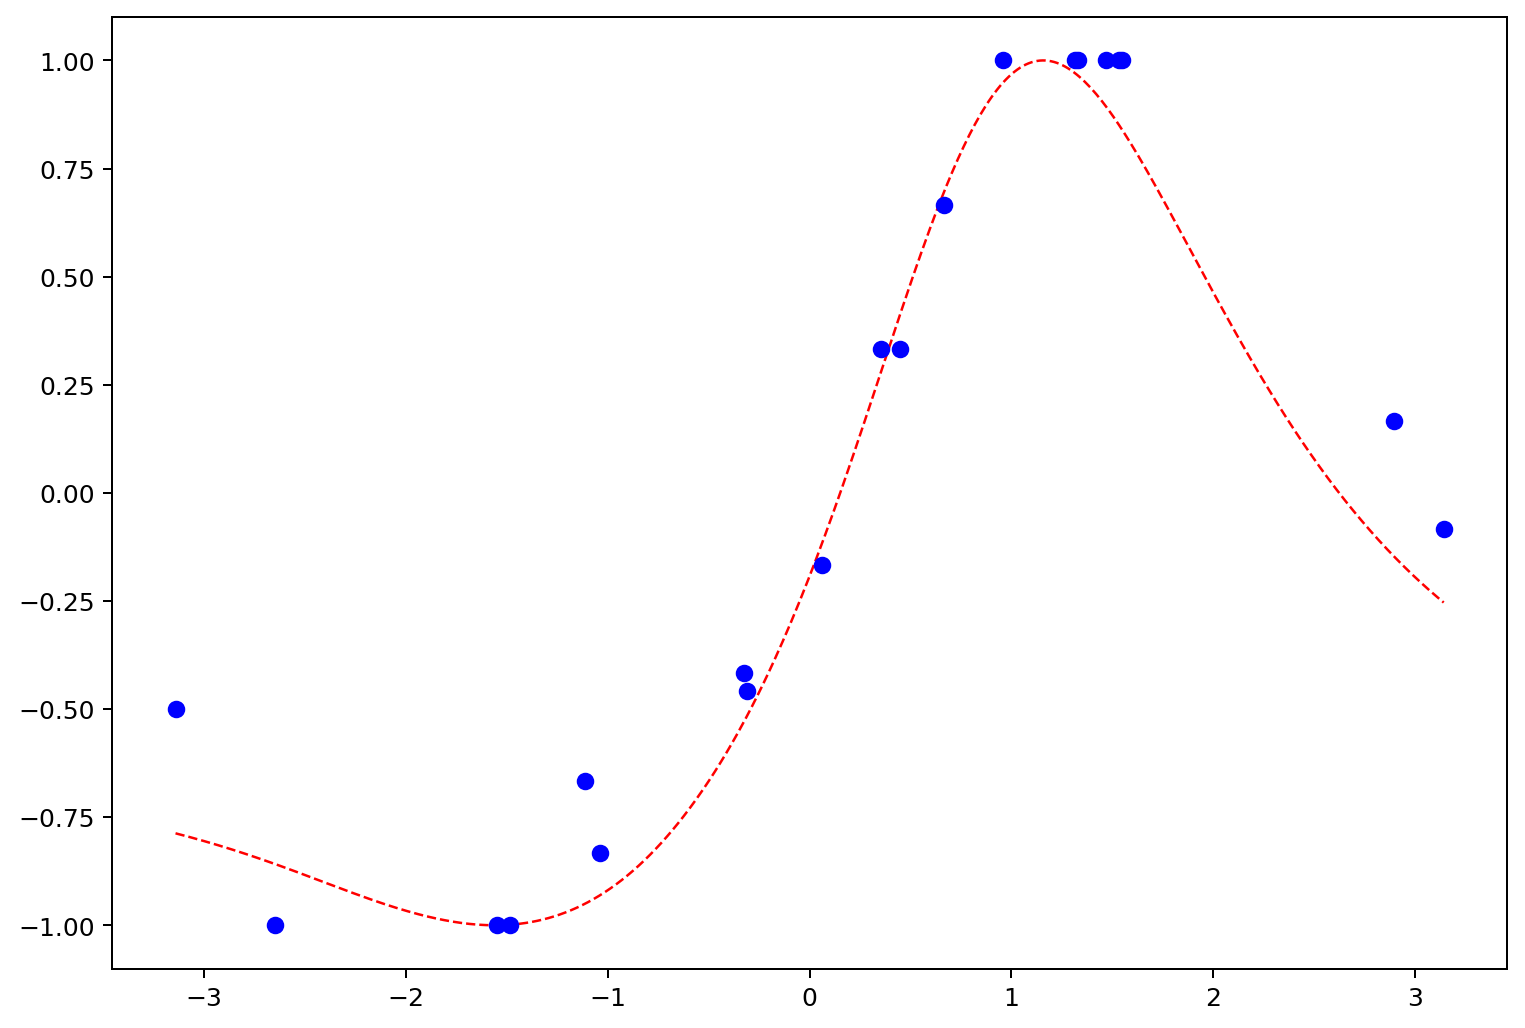

In [6]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

XX = X_[indices].reshape(-1,1)
yy = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

yy = detrend(yy)

#XX = scale(XX, 0, 1)
XX = scale(XX) # from -pi to pi
yy = scale(yy, -1, 1)

#X_ = scale(X_, 0, 1)
X_ = scale(X_) # from -pi to pi
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(XX, yy, "bo", label = 'Points to fit')
plt.show()

In [7]:
def prob_to_angle(prob):
    return 2*asin(sqrt(prob))

In [8]:
def quantum_layer(initial_parameters, num_qubits):

    expectations = []
    
    for i in range(len(initial_parameters)):
        
        quantumCircuit = QuantumCircuit(num_qubits)

        quantumCircuit.h(range(num_qubits))
    
        angles = initial_parameters[i]
        
        for j in range(len(angles)):
            #quantumCircuit.ry(prob_to_angle(angles[j]), i)
            #quantumCircuit.ry(angles[j] * np.pi, i)
            quantumCircuit.ry(angles[j], i)

        quantumCircuit.h(range(num_qubits))
        
        operator = Z
        for _ in range(num_qubits - 1):
            operator ^= Z
            
        psi = StateFn(quantumCircuit)
        expectation_value = (~psi @ operator @ psi).eval()
        
        expectations.append(expectation_value)
 
    diff = num_qubits - len(expectations)
    
    if diff > 0:
        for _ in range(diff):
            expectations.append(0j)
    
    return expectations

In [9]:
class Linear(Layer):
    
    def __init__(self, batch_size = 10, units = 1, input_dim=1, num_qubits = 1,**kwargs):
        
        super(Linear, self).__init__(**kwargs)
        self.num_qubits = num_qubits
        
        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)


    def get_config(self):
        config = super(Linear, self).get_config()
        return config

    def call(self, inputs):
        
        if (tf.executing_eagerly()):
            
            final_output = []
        
            for i in range(inputs.shape[0]):
                pred = quantum_layer(inputs.numpy(), self.num_qubits)
                final_output.append(list(pred))

            return tf.convert_to_tensor(final_output)
        
        return inputs

In [10]:
n_qubits = 10

In [11]:
def sequential_model():

    layers_arr = []
    layers_arr.append(Dense(n_qubits, activation = 'relu', input_shape = [1], name = "dense1"))
    layers_arr.append(Linear(input_dim = n_qubits, num_qubits = n_qubits, name = "quantum"))
    layers_arr.append(Dense(3, activation="linear", name = "dense2"))
    layers_arr.append(Dense(1, name ="dense3"))

    return Sequential(layers_arr)

In [12]:
model = sequential_model()
    
opt = Adam(learning_rate=0.01)
#opt = SGD(learning_rate=0.01)

model.compile(opt, loss='mse', metrics=["accuracy"], run_eagerly=True)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 10)                20        
_________________________________________________________________
quantum (Linear)             (None, 10)                11        
_________________________________________________________________
dense2 (Dense)               (None, 3)                 33        
_________________________________________________________________
dense3 (Dense)               (None, 1)                 4         
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(XX, yy, epochs=150, batch_size=n_qubits, validation_split = 0.25)

#history = model.fit(XX, yy, epochs = 50, batch_size = 8)

Epoch 1/150
2/2 [==============================] - 2s 818ms/step - loss: 0.8174 - accuracy: 0.0000e+00 - val_loss: 0.9459 - val_accuracy: 0.0000e+00
Epoch 2/150
2/2 [==============================] - 2s 765ms/step - loss: 1.3692 - accuracy: 0.0000e+00 - val_loss: 0.8856 - val_accuracy: 0.0000e+00
Epoch 3/150
2/2 [==============================] - 2s 773ms/step - loss: 1.6228 - accuracy: 0.0000e+00 - val_loss: 0.8236 - val_accuracy: 0.0000e+00
Epoch 4/150
2/2 [==============================] - 2s 768ms/step - loss: 0.7397 - accuracy: 0.0000e+00 - val_loss: 0.7773 - val_accuracy: 0.0000e+00
Epoch 5/150
2/2 [==============================] - 2s 779ms/step - loss: 0.6778 - accuracy: 0.0000e+00 - val_loss: 0.7407 - val_accuracy: 0.0000e+00
Epoch 6/150
2/2 [==============================] - 2s 842ms/step - loss: 0.8167 - accuracy: 0.0000e+00 - val_loss: 0.7295 - val_accuracy: 0.0000e+00
Epoch 7/150
2/2 [==============================] - 2s 773ms/step - loss: 0.6776 - accuracy: 0.0000e+00 - v

2/2 [==============================] - 2s 764ms/step - loss: 0.7757 - accuracy: 0.0000e+00 - val_loss: 0.6756 - val_accuracy: 0.0000e+00
Epoch 17/150
2/2 [==============================] - 2s 766ms/step - loss: 0.9854 - accuracy: 0.0667 - val_loss: 0.6723 - val_accuracy: 0.0000e+00
Epoch 18/150
2/2 [==============================] - 2s 766ms/step - loss: 0.5696 - accuracy: 0.0000e+00 - val_loss: 0.6745 - val_accuracy: 0.0000e+00
Epoch 19/150
2/2 [==============================] - 2s 786ms/step - loss: 0.5934 - accuracy: 0.0000e+00 - val_loss: 0.6777 - val_accuracy: 0.0000e+00
Epoch 20/150
2/2 [==============================] - 2s 764ms/step - loss: 0.6622 - accuracy: 0.0000e+00 - val_loss: 0.6841 - val_accuracy: 0.0000e+00
Epoch 21/150
2/2 [==============================] - 2s 807ms/step - loss: 0.6225 - accuracy: 0.0000e+00 - val_loss: 0.6861 - val_accuracy: 0.0000e+00
Epoch 22/150
2/2 [==============================] - 2s 779ms/step - loss: 0.5622 - accuracy: 0.0000e+00 - val_loss: 0

2/2 [==============================] - 2s 766ms/step - loss: 0.5318 - accuracy: 0.0000e+00 - val_loss: 0.6156 - val_accuracy: 0.0000e+00
Epoch 33/150
2/2 [==============================] - 2s 765ms/step - loss: 0.5980 - accuracy: 0.0000e+00 - val_loss: 0.6142 - val_accuracy: 0.0000e+00
Epoch 34/150
2/2 [==============================] - 2s 766ms/step - loss: 0.5567 - accuracy: 0.0000e+00 - val_loss: 0.6132 - val_accuracy: 0.0000e+00
Epoch 35/150
2/2 [==============================] - 2s 793ms/step - loss: 0.6011 - accuracy: 0.0000e+00 - val_loss: 0.6051 - val_accuracy: 0.0000e+00
Epoch 36/150
2/2 [==============================] - 2s 836ms/step - loss: 0.6690 - accuracy: 0.0000e+00 - val_loss: 0.6033 - val_accuracy: 0.0000e+00
Epoch 37/150
2/2 [==============================] - 2s 788ms/step - loss: 0.5942 - accuracy: 0.0000e+00 - val_loss: 0.6036 - val_accuracy: 0.0000e+00
Epoch 38/150
2/2 [==============================] - 2s 762ms/step - loss: 0.5580 - accuracy: 0.0000e+00 - val_los

2/2 [==============================] - 2s 766ms/step - loss: 0.5849 - accuracy: 0.0000e+00 - val_loss: 0.6479 - val_accuracy: 0.0000e+00
Epoch 48/150
2/2 [==============================] - 2s 766ms/step - loss: 0.6142 - accuracy: 0.0000e+00 - val_loss: 0.6565 - val_accuracy: 0.0000e+00
Epoch 49/150
2/2 [==============================] - 2s 860ms/step - loss: 0.5426 - accuracy: 0.0000e+00 - val_loss: 0.6663 - val_accuracy: 0.0000e+00
Epoch 50/150
2/2 [==============================] - 2s 767ms/step - loss: 0.5480 - accuracy: 0.0000e+00 - val_loss: 0.6741 - val_accuracy: 0.0000e+00
Epoch 51/150
2/2 [==============================] - 2s 767ms/step - loss: 0.5552 - accuracy: 0.0000e+00 - val_loss: 0.6799 - val_accuracy: 0.0000e+00
Epoch 52/150
2/2 [==============================] - 2s 833ms/step - loss: 0.5589 - accuracy: 0.0000e+00 - val_loss: 0.6863 - val_accuracy: 0.0000e+00
Epoch 53/150
2/2 [==============================] - 2s 785ms/step - loss: 0.6246 - accuracy: 0.0000e+00 - val_los

2/2 [==============================] - 2s 780ms/step - loss: 0.5333 - accuracy: 0.0000e+00 - val_loss: 0.7728 - val_accuracy: 0.0000e+00
Epoch 64/150
2/2 [==============================] - 2s 770ms/step - loss: 0.5518 - accuracy: 0.0000e+00 - val_loss: 0.7815 - val_accuracy: 0.0000e+00
Epoch 65/150
2/2 [==============================] - 2s 837ms/step - loss: 0.5486 - accuracy: 0.0000e+00 - val_loss: 0.7894 - val_accuracy: 0.0000e+00
Epoch 66/150
2/2 [==============================] - 2s 771ms/step - loss: 0.5541 - accuracy: 0.0000e+00 - val_loss: 0.7966 - val_accuracy: 0.0000e+00
Epoch 67/150
2/2 [==============================] - 2s 761ms/step - loss: 0.5549 - accuracy: 0.0000e+00 - val_loss: 0.8026 - val_accuracy: 0.0000e+00
Epoch 68/150
2/2 [==============================] - 2s 764ms/step - loss: 0.5821 - accuracy: 0.0000e+00 - val_loss: 0.8033 - val_accuracy: 0.0000e+00
Epoch 69/150
2/2 [==============================] - 2s 787ms/step - loss: 0.5432 - accuracy: 0.0000e+00 - val_los

2/2 [==============================] - 2s 855ms/step - loss: 0.5108 - accuracy: 0.0000e+00 - val_loss: 0.8361 - val_accuracy: 0.0000e+00
Epoch 79/150
2/2 [==============================] - 2s 762ms/step - loss: 0.5499 - accuracy: 0.0000e+00 - val_loss: 0.8460 - val_accuracy: 0.0000e+00
Epoch 80/150
2/2 [==============================] - 2s 771ms/step - loss: 0.5651 - accuracy: 0.0000e+00 - val_loss: 0.8525 - val_accuracy: 0.0000e+00
Epoch 81/150
2/2 [==============================] - 2s 767ms/step - loss: 0.5539 - accuracy: 0.0000e+00 - val_loss: 0.8556 - val_accuracy: 0.0000e+00
Epoch 82/150
2/2 [==============================] - 2s 762ms/step - loss: 0.5636 - accuracy: 0.0000e+00 - val_loss: 0.8583 - val_accuracy: 0.0000e+00
Epoch 83/150
2/2 [==============================] - 2s 773ms/step - loss: 0.5590 - accuracy: 0.0000e+00 - val_loss: 0.8616 - val_accuracy: 0.0000e+00
Epoch 84/150
2/2 [==============================] - 2s 795ms/step - loss: 0.5180 - accuracy: 0.0000e+00 - val_los

2/2 [==============================] - 2s 768ms/step - loss: 0.5395 - accuracy: 0.0000e+00 - val_loss: 0.8194 - val_accuracy: 0.0000e+00
Epoch 95/150
2/2 [==============================] - 2s 760ms/step - loss: 0.5499 - accuracy: 0.0000e+00 - val_loss: 0.8172 - val_accuracy: 0.0000e+00
Epoch 96/150
2/2 [==============================] - 2s 792ms/step - loss: 0.5446 - accuracy: 0.0000e+00 - val_loss: 0.8125 - val_accuracy: 0.0000e+00
Epoch 97/150
2/2 [==============================] - 2s 766ms/step - loss: 0.5638 - accuracy: 0.0000e+00 - val_loss: 0.7990 - val_accuracy: 0.0000e+00
Epoch 98/150
2/2 [==============================] - 2s 790ms/step - loss: 0.5474 - accuracy: 0.0000e+00 - val_loss: 0.7894 - val_accuracy: 0.0000e+00
Epoch 99/150
2/2 [==============================] - 2s 774ms/step - loss: 0.5649 - accuracy: 0.0000e+00 - val_loss: 0.7830 - val_accuracy: 0.0000e+00
Epoch 100/150
2/2 [==============================] - 2s 766ms/step - loss: 0.5539 - accuracy: 0.0000e+00 - val_lo

2/2 [==============================] - 2s 766ms/step - loss: 0.5854 - accuracy: 0.0000e+00 - val_loss: 0.7634 - val_accuracy: 0.0000e+00
Epoch 110/150
2/2 [==============================] - 2s 762ms/step - loss: 0.5263 - accuracy: 0.0000e+00 - val_loss: 0.7685 - val_accuracy: 0.0000e+00
Epoch 111/150
2/2 [==============================] - 2s 767ms/step - loss: 0.5539 - accuracy: 0.0000e+00 - val_loss: 0.7747 - val_accuracy: 0.0000e+00
Epoch 112/150
2/2 [==============================] - 2s 835ms/step - loss: 0.5594 - accuracy: 0.0000e+00 - val_loss: 0.7784 - val_accuracy: 0.0000e+00
Epoch 113/150
2/2 [==============================] - 2s 762ms/step - loss: 0.5796 - accuracy: 0.0000e+00 - val_loss: 0.7827 - val_accuracy: 0.0000e+00
Epoch 114/150
2/2 [==============================] - 2s 766ms/step - loss: 0.5534 - accuracy: 0.0000e+00 - val_loss: 0.7872 - val_accuracy: 0.0000e+00
Epoch 115/150
2/2 [==============================] - 2s 769ms/step - loss: 0.5165 - accuracy: 0.0000e+00 - v

2/2 [==============================] - 2s 764ms/step - loss: 0.5510 - accuracy: 0.0000e+00 - val_loss: 0.7871 - val_accuracy: 0.0000e+00
Epoch 126/150
2/2 [==============================] - 2s 789ms/step - loss: 0.5562 - accuracy: 0.0000e+00 - val_loss: 0.7922 - val_accuracy: 0.0000e+00
Epoch 127/150
2/2 [==============================] - 2s 771ms/step - loss: 0.5329 - accuracy: 0.0000e+00 - val_loss: 0.7899 - val_accuracy: 0.0000e+00
Epoch 128/150
2/2 [==============================] - 2s 773ms/step - loss: 0.5175 - accuracy: 0.0000e+00 - val_loss: 0.7905 - val_accuracy: 0.0000e+00
Epoch 129/150
2/2 [==============================] - 2s 774ms/step - loss: 0.5182 - accuracy: 0.0000e+00 - val_loss: 0.7908 - val_accuracy: 0.0000e+00
Epoch 130/150
2/2 [==============================] - 3s 916ms/step - loss: 0.4955 - accuracy: 0.0000e+00 - val_loss: 0.7888 - val_accuracy: 0.0000e+00
Epoch 131/150
2/2 [==============================] - 2s 777ms/step - loss: 0.5503 - accuracy: 0.0000e+00 - v

2/2 [==============================] - 2s 770ms/step - loss: 0.5167 - accuracy: 0.0000e+00 - val_loss: 0.8260 - val_accuracy: 0.0000e+00
Epoch 141/150
2/2 [==============================] - 2s 789ms/step - loss: 0.6272 - accuracy: 0.0000e+00 - val_loss: 0.8286 - val_accuracy: 0.0000e+00
Epoch 142/150
2/2 [==============================] - 2s 774ms/step - loss: 0.5503 - accuracy: 0.0000e+00 - val_loss: 0.8327 - val_accuracy: 0.0000e+00
Epoch 143/150
2/2 [==============================] - 2s 766ms/step - loss: 0.5511 - accuracy: 0.0000e+00 - val_loss: 0.8421 - val_accuracy: 0.0000e+00
Epoch 144/150
2/2 [==============================] - 2s 767ms/step - loss: 0.5593 - accuracy: 0.0000e+00 - val_loss: 0.8518 - val_accuracy: 0.0000e+00
Epoch 145/150
2/2 [==============================] - 2s 762ms/step - loss: 0.5859 - accuracy: 0.0000e+00 - val_loss: 0.8563 - val_accuracy: 0.0000e+00
Epoch 146/150
2/2 [==============================] - 2s 761ms/step - loss: 0.5744 - accuracy: 0.0000e+00 - v

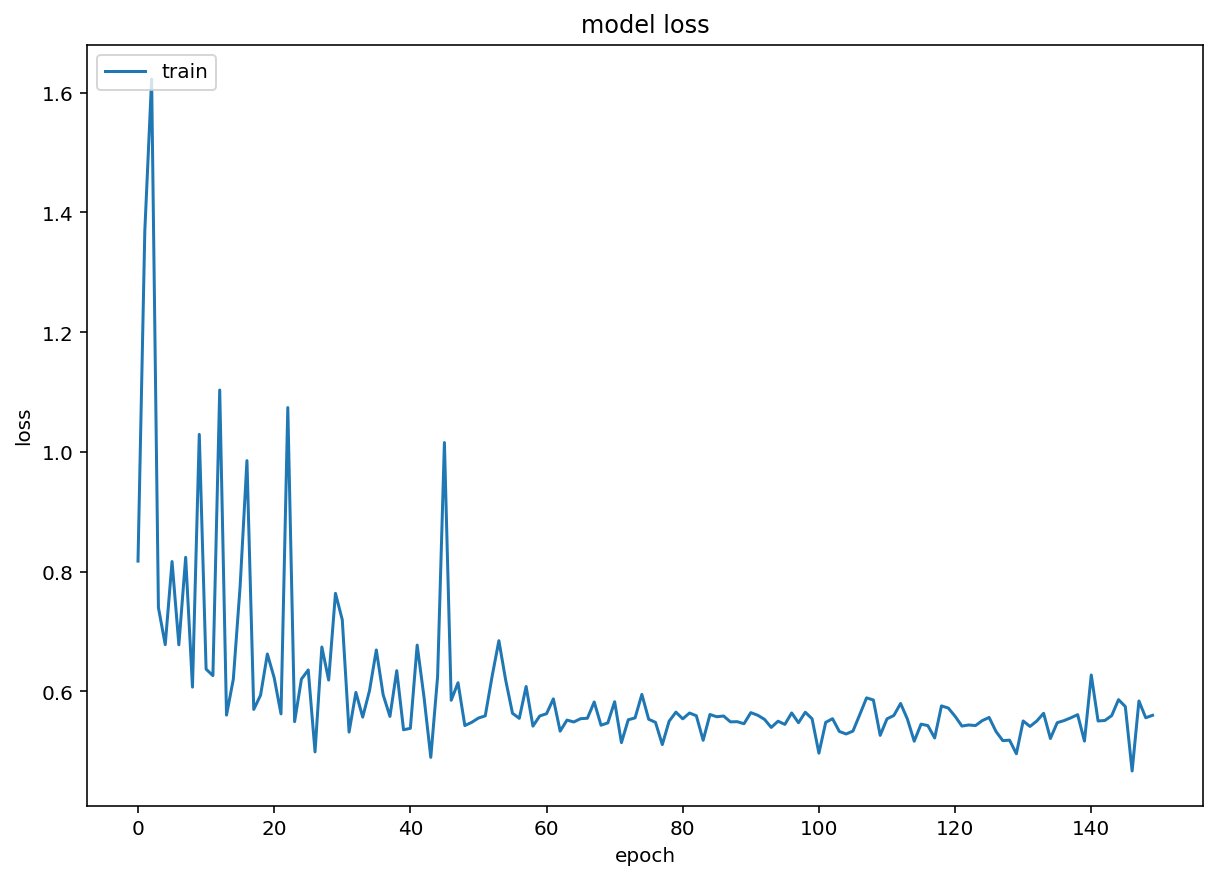

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [16]:
splitted_X = None

if n_qubits > 1:
    num_sections = ceil(X_.shape[0] / n_qubits)
    splitted_X = np.array_split(X_.flatten(), num_sections)
else:
    splitted_X = X_

In [17]:
y_predict = []

for arr in splitted_X:
    pred = model.predict(arr)
    y_predict.append(pred.tolist())

In [18]:
y_predict_array = np.array(y_predict)

In [19]:
y_predict_smooth = smooth(y_predict)

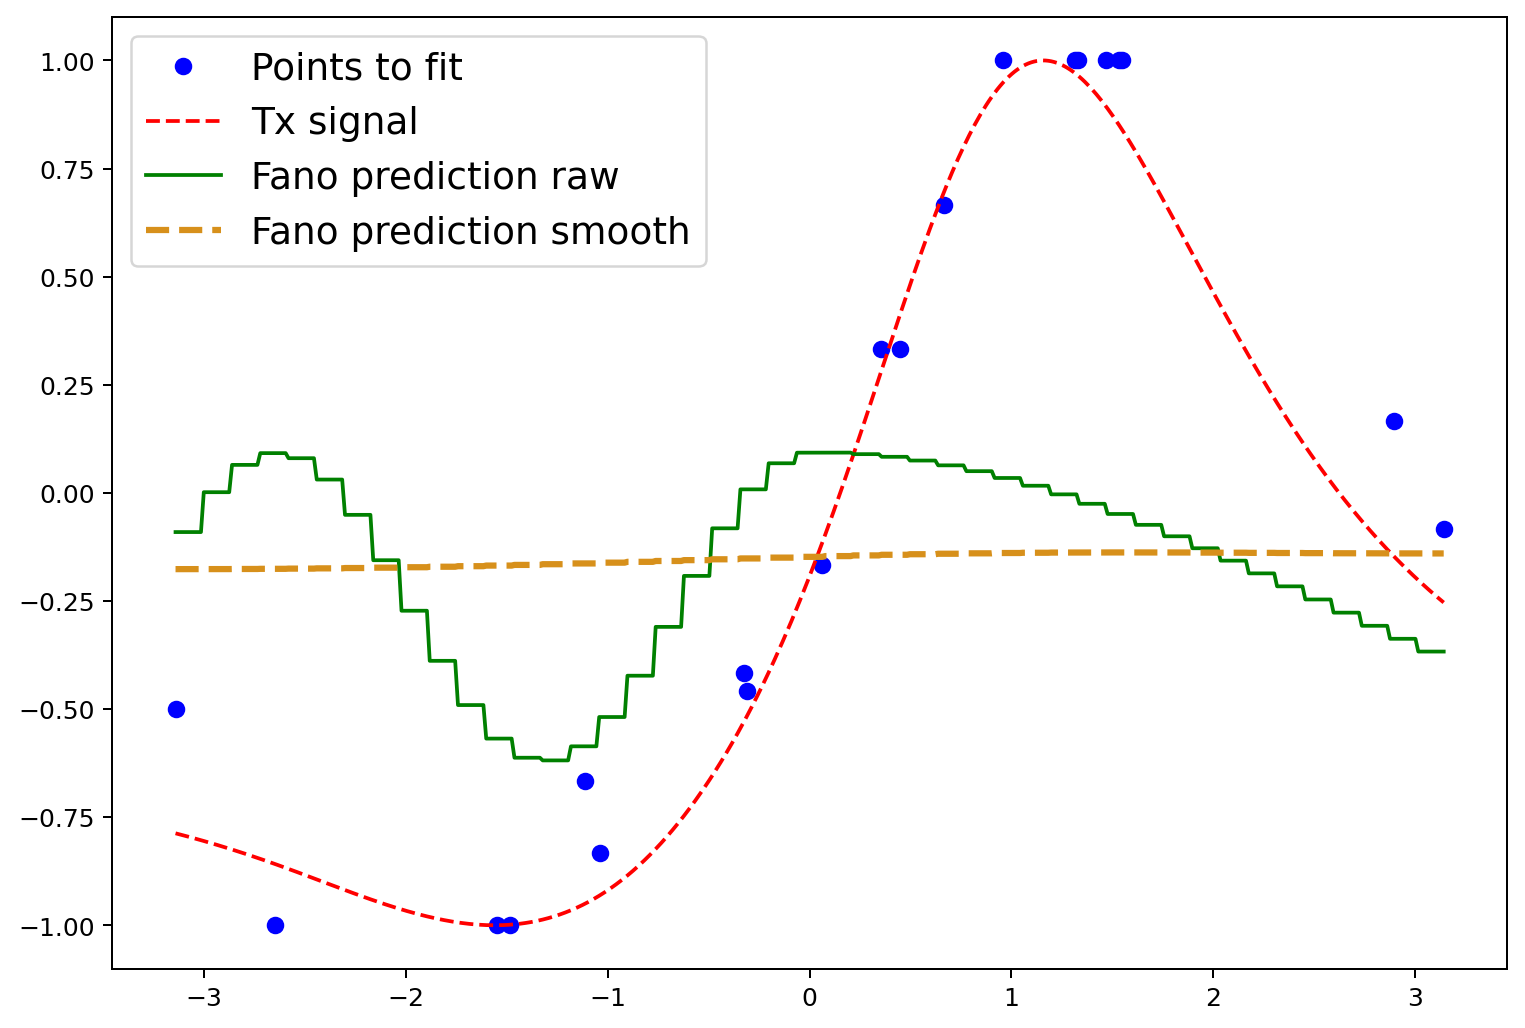

In [20]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(XX, yy, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict_array.flatten(), "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth.flatten(), "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [21]:
print("Score: %.10f" % r2_score(y_, y_predict_array.flatten()))

Score: 0.1977912656
